In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import jsonargparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_violin_comparison
from cdi.util.analysis.eval import (compute_avg_kl_divergence,
                                    compute_avg_symmetrised_kl_divergence,
                                    compute_avg_wasserstein_distance,
                                    compute_gaussian_kl_div,
                                    compute_avg_num_var_updates_per_dim)
from cdi.trainers.trainer_base import TrainerBase
from cdi.trainers.posterior_cdi import PosteriorCDI


## Analysis setup

### Global settings

In [6]:
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm2019050811_d2020032511_20200406_20200407',
    'm2019050822_d2020032522_20200406_20200407',
    'm2019050833_d2020032533_20200406_20200407',
    'm2019050844_d2020032544_20200406_20200407',
]

### Templates

In [7]:
log_path_base = '../../trained_models/{}/learning_experiments'

## Helpers

In [8]:
def merge_dicts(a, b, path=None):
    "merges b into a"
    if path is None: path = []
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] == b[key]:
                pass # same leaf value
            else:
                raise Exception('Conflict at %s' % '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a

## Independent variational posterior analysis

### KL-divergence analysis $D_{\text{KL}}(q(x^j \mid x^{\smallsetminus j})||p(x^j \mid x^{\smallsetminus j}))$a

In [9]:
toy_suite = {
    'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs_fixvarwarmup',
}
frey_suite = {
    'VCDI': 'fa_pretrained_svar_cdi_const',
}
groups = [1, 2, 3, 4, 5]

In [10]:
toy_stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in toy_suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base.format('toy_set3'))
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base.format('toy_set3'))
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base.format('toy_set3'))

    toy_stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = toy_stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
    toy_stats[exp_name]['test_avg_kldiv_var_truth_all'] = toy_stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    toy_stats[exp_name]['test_avg_kldiv_var_anal_all'] = toy_stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    toy_stats[exp_name]['test_avg_kldiv_var_truth'] = toy_stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=1)
    toy_stats[exp_name]['test_avg_kldiv_var_anal'] = toy_stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=1)
    
    toy_stats[exp_name]['test_avg_kldiv_var_truth_median'] = np.median(axis=1, a=toy_stats[exp_name]['test_avg_kldiv_var_truth_all'])
    toy_stats[exp_name]['test_avg_kldiv_var_anal_median'] = np.median(axis=1, a=toy_stats[exp_name]['test_avg_kldiv_var_anal_all'])
    
    toy_stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = toy_stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
    toy_stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = toy_stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)

    toy_stats[exp_name]['test_kldiv_all'] = np.concatenate([toy_stats[exp_name]['test_avg_kldiv_var_truth_all'], 
                                                        toy_stats[exp_name]['test_avg_kldiv_var_anal_all']],
                                                       axis=1)

    toy_stats[exp_name]['test_kldiv_all_hue'] = np.concatenate([np.full(toy_stats[exp_name]['test_avg_kldiv_var_truth_all'].shape,
                                                                    fill_value=0),
                                                            np.full(toy_stats[exp_name]['test_avg_kldiv_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=1)

for method, experiments in toy_stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]

In [11]:
frey_stats = {}
# Load stats for every experiment in the suite
for exp_name, model_name in frey_suite.items():
    stats1 = compute_avg_kl_divergence(model1=model_name,
                                       model2='fa_ground_truth_cdi',
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base.format('fa_frey_processed'))
    stats2 = compute_avg_kl_divergence(model1=model_name,
                                       model2=model_name,
                                       model1_posterior_key='var',
                                       model2_posterior_key='anal',
                                       out_key='var_anal',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base.format('fa_frey_processed'))
    stats3 = compute_avg_kl_divergence(model1='fa_ground_truth_cdi',
                                       model2=model_name,
                                       model1_posterior_key='anal',
                                       model2_posterior_key='anal',
                                       out_key='model_truth',
                                       seeds=exp_seed_keys,
                                       groups=groups,
                                       base_path=log_path_base.format('fa_frey_processed'))

    frey_stats[exp_name] = {**stats1, **stats2, **stats3}
    
    dim0 = frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0]
    frey_stats[exp_name]['test_avg_kldiv_var_truth_all'] = frey_stats[exp_name]['test_avg_kldiv_var_truth_all'].reshape(dim0, -1)
    frey_stats[exp_name]['test_avg_kldiv_var_anal_all'] = frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].reshape(dim0, -1)
    
    # Re-Calculate mean and stderr across all dimensions
    frey_stats[exp_name]['test_avg_kldiv_var_truth'] = frey_stats[exp_name]['test_avg_kldiv_var_truth_all'].mean(axis=1)
    frey_stats[exp_name]['test_avg_kldiv_var_anal'] = frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].mean(axis=1)
    
    frey_stats[exp_name]['test_avg_kldiv_var_truth_median'] = np.median(axis=1, a=frey_stats[exp_name]['test_avg_kldiv_var_truth_all'])
    frey_stats[exp_name]['test_avg_kldiv_var_anal_median'] = np.median(axis=1, a=frey_stats[exp_name]['test_avg_kldiv_var_anal_all'])
    
    frey_stats[exp_name]['test_avg_kldiv_std_err_var_truth'] = frey_stats[exp_name]['test_avg_kldiv_var_truth_all'].std(axis=1, ddof=1)
    frey_stats[exp_name]['test_avg_kldiv_std_err_var_anal'] = frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].std(axis=1, ddof=1)

#     frey_stats[exp_name]['test_kldiv_all'] = np.concatenate([frey_stats[exp_name]['test_avg_kldiv_var_truth_all'], 
#                                                         frey_stats[exp_name]['test_avg_kldiv_var_anal_all']],
#                                                        axis=1)

#     frey_stats[exp_name]['test_kldiv_all_hue'] = np.concatenate([np.full(frey_stats[exp_name]['test_avg_kldiv_var_truth_all'].shape,
#                                                                     fill_value=0),
#                                                             np.full(frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].shape,
#                                                                     fill_value=1)],
#                                                            axis=1)
    
    # Hack for plotting half-violins
    dummy = np.full((frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].shape[0], 1), 
                    fill_value=-0.2)
    frey_stats[exp_name]['test_avg_kldiv_var_truth_all_hack'] = np.concatenate([dummy, 
                                                                          frey_stats[exp_name]['test_avg_kldiv_var_truth_all']],
                                                       axis=-1)
    frey_stats[exp_name]['test_avg_kldiv_var_anal_all_hack'] = np.concatenate([dummy, 
                                                                          frey_stats[exp_name]['test_avg_kldiv_var_anal_all']],
                                                       axis=-1)

    frey_stats[exp_name]['test_avg_kldiv_var_truth_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=1),
                                                            np.full(frey_stats[exp_name]['test_avg_kldiv_var_truth_all'].shape,
                                                                    fill_value=0)],
                                                           axis=-1)
    frey_stats[exp_name]['test_avg_kldiv_var_anal_all_hack_hue'] = np.concatenate([np.full(dummy.shape,
                                                                    fill_value=0),
                                                            np.full(frey_stats[exp_name]['test_avg_kldiv_var_anal_all'].shape,
                                                                    fill_value=1)],
                                                           axis=-1)
    

for method, experiments in frey_stats.items():
    experiments['group2'] = experiments['group']
    experiments['group'] = [experiments['group']]

#### Merged-dimension violinplot, only keep $\text{KL}(q \mid p^*)$ and $\text{KL}(q \mid p_\theta)$

<IPython.core.display.Javascript object>


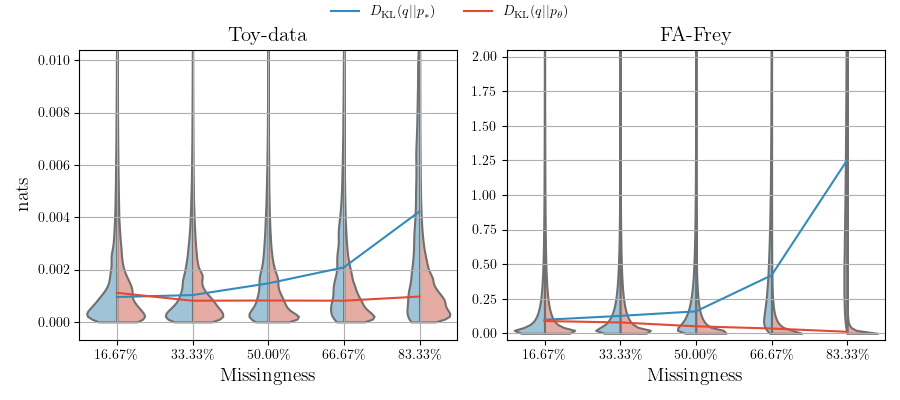

In [16]:
# Toy

# Define metrics for plot
y_metrics = ('test_kldiv_all',)
y_hue_key = 'test_kldiv_all_hue'

y_metrics_line = ('test_avg_kldiv_var_truth_median',
                  'test_avg_kldiv_var_anal_median',
                  #'test_avg_kldiv_model_truth_median'
                 )
err_metrics = (None, None)
metric_labels = ('$D_{\\mathrm{KL}}(q||p_*)$',
                 '$D_{\\mathrm{KL}}(q||p_{\\theta})$',
                 #'$D_{\\mathrm{KL}}(p_*||p_{\\theta})$'
                )

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
colors = ['#348ABD', '#E24A33']
# colors_violin = ['#8bbfe4', '#f6b276]
# Slightly lighter colors for the KDEs
colors_violin = ['#95c5e1', '#f0a499' ]

ylabel='nats'
xlabel='Missingness'

bw=None
width=None
plot_seaborn_violin_comparison(axes[0], toy_stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics,
                y_metric_dim=None,
                y_hue_key=y_hue_key,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                gridsize=100,
                inner=None,
                cut=0.,
                upper_boundaries=0.0105)

plot_comparison(axes[0], toy_stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=ylabel, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2],
                legend_loc='upper left')

axes[0].xaxis.set_ticks(groups)
axes[0].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
axes[0].set_xlim(0.5, 5.5)
axes[0].grid()
    
axes[0].set_ylim(-0.0007, 0.0104)

# fig.tight_layout()

axes[0].set_title('Toy-data', fontsize=15)


#  Frey

y_metrics1 = ('test_avg_kldiv_var_truth_all_hack',)
y_hue_key1 = 'test_avg_kldiv_var_truth_all_hack_hue'
y_metrics2 = ('test_avg_kldiv_var_anal_all_hack',)
y_hue_key2 = 'test_avg_kldiv_var_anal_all_hack_hue'

plot_seaborn_violin_comparison(axes[1], frey_stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics1,
                y_metric_dim=None,
                y_hue_key=y_hue_key1,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=None, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=False,
                cut=0.,
                upper_boundaries=2.1)

plot_seaborn_violin_comparison(axes[1], frey_stats, 
                x_metric_key='group',
                y_metric_keys=y_metrics2,
                y_metric_dim=None,
                y_hue_key=y_hue_key2,
                metric_labels=(None,),
                xlabel=xlabel,
                ylabel=None, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors_violin[:2],
                band_width=bw,
                width=width,
                gridsize=100,
                inner=None,
                scale='area',
                scale_hue=True,
                cut=0.,
                upper_boundaries=2.1)

plot_comparison(axes[1], frey_stats, 
                x_metric_key='group2',
                y_metric_keys=y_metrics_line,
                y_metric_dim=None,
                err_keys=err_metrics,
                err_metric_dim=None,
                metric_labels=metric_labels,
                xlabel=xlabel,
                ylabel=None, 
                ylim=None,
                colors_instead_styles=True,
                colors=colors[:2])

axes[1].get_legend().remove()

axes[1].set_ylim(-0.05, 2.05)
axes[1].xaxis.set_ticks(groups)
axes[1].set_xticklabels(list(f'{g/6*100:.2f}\\%' for g in groups))
axes[1].set_xlim(0.5, 5.5)

axes[1].set_title('FA-Frey', fontsize=15)


fig.tight_layout(rect=(0, 0, 1, 0.97))

handles, labels = axes[0].get_legend_handles_labels()

axes[0].legend(handles[2:], labels[2:],
            ncol=2, bbox_to_anchor=(0.5, 0.97), bbox_transform=fig.transFigure, loc='center', frameon=False)

In [18]:
# fig.savefig('figures/toy_and_fafrey_mcar_posterior_kldiv_merged.pdf', bbox_inches='tight')